In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        # 输入形状: (batch, 3, 150, 150)
        super(Net, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 32, 150, 150)
            torch.nn.BatchNorm2d(32),  # 增加 Batch Normalization 提高训练稳定性
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 32, 75, 75)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 64, 75, 75)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 64, 37, 37)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 128, 37, 37)
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 128, 18, 18)
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 256, 18, 18)
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 256, 9, 9)
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(256 * 9 * 9, 512),  # 全连接层, 输入: 128*18*18
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),  # 添加 Dropout 防止过拟合
            torch.nn.Linear(512, 2)  # 最后输出 2 个类别
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 第一卷积模块
        x = self.conv2(x)  # 第二卷积模块
        x = self.conv3(x)  # 第三卷积模块
        x = self.conv4(x)  # 第四卷积模块
        x = x.view(batch_size, -1)  # 展平为全连接层输入
        x = self.fc(x)  # 全连接层
        return x  # 输出形状: (batch, 2)

model = Net().to(device)
model_path = '../models/2_Cat_Dog_Image_Classification/model_weights.pth'
# 加载模型参数
model.load_state_dict(torch.load(model_path))
# 将模型设置为评估模式
model.eval()

C:\Users\PC\AppData\Local\Temp\ipykernel_17476\2859453448.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(

In [4]:
# 预测函数
def predict_image(image_path, model, classes=['Cat', 'Dog']):
    image = Image.open(image_path)
    # 图像预处理  与模型训练数据处理匹配
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # 随机水平翻转，增强样本的多样性，概率为 50%
        transforms.RandomRotation(15),  # 随机旋转图像，角度范围为 -15° 到 15°
        transforms.ColorJitter(          # 随机调整图像的颜色属性：
            brightness=0.01,             # 调整亮度，范围为 [0.8, 1.2]（1±0.2）
            contrast=0.01,               # 调整对比度，范围为 [0.8, 1.2]
            saturation=0.01,             # 调整饱和度，范围为 [0.8, 1.2]
            hue=0.01                     # 调整色调，范围为 [-0.1, 0.1]
        ),
        transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),  # 把图片的每一个channel随机裁剪成 150x150, 裁剪比例范围为 80% - 100%
        transforms.ToTensor(),             # 将图像转换为张量，并将像素值归一化到 [0, 1]
        transforms.Normalize(              # 对张量进行标准化处理, 提升模型训练的稳定性
            mean=[0.485, 0.456, 0.406],    # 使用 ImageNet 数据集的均值
            std=[0.229, 0.224, 0.225]      # 使用 ImageNet 数据集的标准差
        ),
    ])
    image = transform(image)
    image = image.to(device)
    image = image.unsqueeze(0)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    return classes[predicted.item()]

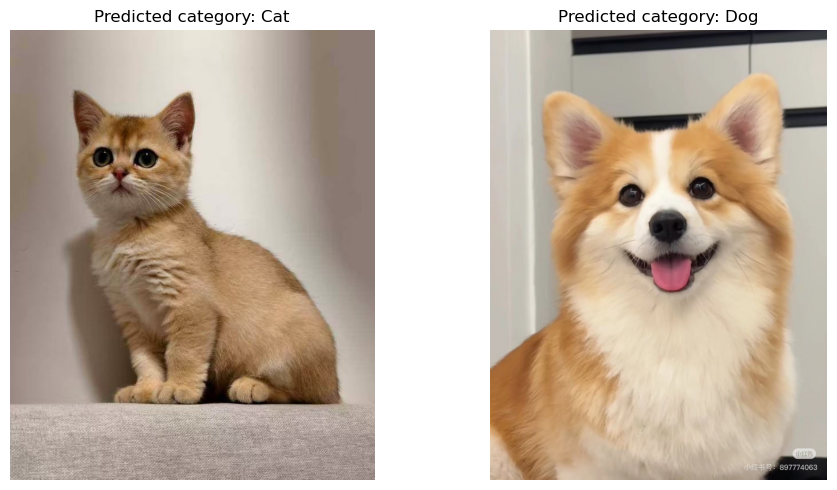

In [5]:
#展示图片及它们对应的预测标签

cat_path = './data/cat.jpg'
dog_path = './data/dog.jpg'

# 显示图像及预测结果
plt.figure(figsize=(10, 5))

# 猫图像
plt.subplot(1, 2, 1)
cat_predicted = predict_image(cat_path, model)
plt.imshow(Image.open(cat_path))
plt.title(f"Predicted category: {cat_predicted}")
plt.axis('off')

# 狗图像
plt.subplot(1, 2, 2)
dog_predicted = predict_image(dog_path, model)
plt.imshow(Image.open(dog_path))
plt.title(f"Predicted category: {dog_predicted}")
plt.axis('off')

# 显示结果
plt.tight_layout()
plt.show()